In [36]:
%load_ext autoreload
%autoreload 2
import sys
import os
from decimal import *

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gc


from IPython import display
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

sys.path.append('../dataset_construction')
sys.path.append('../../util')
from pano_utils import *
from panoseti_file_interfaces import ObservingRunInterface


from cnn_model import *
from data_loaders import *
from training_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# Frame browsing utils
# cloudy = labeled[labeled['label'] == 'not_clear_cloudy']
# clear = labeled[labeled['label'] == 'clear_night_sky']
img_type = 'raw-derivative.-60'
# img_type = 'raw-original'
# img_type = 'raw-fft'

def make_img_grid(label, cols=8, rows_per_plot=6):
    """Grid of all classified images labeled as the given label"""
    with_label = labeled.loc[labeled['label'] == label]
    imgs = []

    for fuid in with_label['feature_uid']:
        data = np.load(get_path(fuid, img_type), allow_pickle=False)
        imgs.append(data)
    if len(imgs) == 0:
        print(f'No images labeled as "{label}"')
        return
    else:
        print(f'Images you classified as "{label}":')
    # Limit num rows in plot to ensure consistently-sized figures
    rows = math.ceil(len(imgs) / cols)
    num_subplots = rows_per_plot * cols
    for plot_idx in range(math.ceil(rows / rows_per_plot)):
        fig = plt.figure(figsize=(3. * rows_per_plot, 3. * cols))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(rows_per_plot, cols),  # creates width x height grid of axes
                         axes_pad=0.3,  # pad between axes in inch.
                         )
        for i in range(num_subplots):
            img_idx = plot_idx * num_subplots + i
            if img_idx < len(imgs):
                ax = grid[i]
                img = imgs[img_idx]
                feature_uid = with_label['feature_uid'].iloc[img_idx]
                ax.set_title(f'{23}{feature_uid[:6]}')  # Label each plot with first 6 chars of feature_uid
                ax.imshow(img, vmin=-150, vmax=150, cmap='icefire')
        plt.show()
        plt.close()

def add_module_id_and_time(df):
    df_with_pano_uid = pd.merge(
        left = df,
        right = inference_data.inference_session.feature_df,
        on = 'feature_uid'
    )
    df_with_module_id_and_time = pd.merge(
        left = df_with_pano_uid,
        right = inference_data.inference_session.pano_df,
        on = 'pano_uid'
    ).loc[:,['feature_uid', 'module_id', 'label', 'frame_unix_t']]
    df_with_module_id_and_time['date'] = pd.to_datetime(df_with_module_id_and_time['frame_unix_t'], unit='s')
    return df_with_module_id_and_time

def get_with_label(label, module_id):
    if label == 'cloudy':
        with_label = cloudy
    elif label == 'clear':
        with_label = clear
    else:
        raise ValueError('label must be either "cloudy" or "clear"')
    if module_id != 'All':
        assert 'module_id' in with_label, "'module_id' must be added to the data frame."
        assert module_id in with_label['module_id'].unique(), f"Found no data with module_id = {module_id}."
        with_label = with_label[with_label['module_id'] == module_id]
    return with_label


def do_movie(label, step, start_frame=1, frame_time=0.01, module_id=None):
    try:
        # for i, fuid in enumerate(with_label['feature_uid'][::step]):
        with_label = get_with_label(label, module_id)

        for i in range(max(min(start_frame, len(with_label)), 1), len(with_label) + 1, step):
            plot_frame(module_id, label, step, i)
            display.clear_output(wait=True)
            # plt.show()
            sleep(frame_time)
            # plt.close()
        print('Done')
    except KeyboardInterrupt:
        print('Exiting...')
        return
    finally:
        plt.close()
        gc.collect()


def browse_labels(continuous_update=True):
    try:
        initial_label = 'cloudy'
        label_options = ['cloudy', 'clear']
        if len(cloudy) == 0 and len(clear) == 0:
            raise ValueError('No images!')
        elif len(cloudy) == 0:
            initial_label = 'clear'
            label_options.remove('cloudy')
        initial_df = get_with_label(initial_label, module_id='All')

        module_id_options = ['All']
        module_id_options.extend(list(labeled['module_id'].unique()))
        # print(module_id_options)
        
        i_widget = widgets.IntSlider(
            min=1,
            max=len(initial_df),
            step=1,
            value=1, 
            description='seqno',
            continuous_update=continuous_update,
            layout=Layout(width='85%'),
            auto_advance=True)
        label_widget = widgets.Dropdown(
            options=label_options,
            value = initial_label,
            description='label',
            layout=Layout(width='50%', justify_content='center')
        )
        module_id_widget = widgets.Dropdown(
            options=module_id_options,
            value = 'All',
            description='module_id',
            layout=Layout(width='50%', justify_content='center')
        )

        def update_i_widget(*args):
            label = label_widget.value
            module_id = module_id_widget.value
            with_label = get_with_label(label, module_id)
            i_widget.max = len(with_label)
            i_widget.value = min(i_widget.value, len(with_label))
                
        label_widget.observe(update_i_widget, 'value')
        module_id_widget.observe(update_i_widget, 'value')
        interact(
            plot_frame,
            label = label_widget,
            step = fixed(1),
            i = i_widget,
            module_id = module_id_widget
        )
    except KeyboardInterrupt:
        print('Exiting...')
        return
    finally:
        plt.close()
        gc.collect()


def plot_frame(module_id, label, step, i):
    with_label = get_with_label(label, module_id)
    fuid, actual_module_id, date = with_label[['feature_uid', 'module_id', 'date']].iloc[i - 1]
    data = np.load(get_path(fuid, img_type))    
    fig, axs = plt.subplots(1, 3, figsize=(10.5, 4.8), constrained_layout=True)
    # fig.suptitle(f'[{label}] feature_uid: {fuid[:9]:>10}; ({(i-1)//step + 1} / {len(with_label) // step})')
    fig.suptitle(f'[inference: "{label}"] '
                 f'[module: {actual_module_id}] '
                 f'[fuid: {fuid[:9]}] '
                 f'[seqno: {i} / {len(with_label)}]\n'
                 f'[UTC: {date}]')

    # FFT of original stacked original
    fft_idx = 0
    shape = (64, 64)
    data = np.load(get_path(fuid, 'raw-derivative.-60'))
    window_type = "hann"
    data = data * window(window_type, data.shape)
    # data[data < 0] = 1
    data = np.abs(fftn(data, shape))
    data = fftshift(data)
    data = np.log(data)
    im_fft = axs[fft_idx].imshow(
        data, vmin=3.5, vmax=8, cmap='mako'
    )
    cbar_fft = fig.colorbar(im_fft, label='$\log|X[k, \ell]|$', fraction=0.046, location='bottom')
    axs[fft_idx].axis('off')
    axs[fft_idx].set_title('FFT of Derivative')

    # Original stacked pano image
    orig_idx = 2
    im_orig = axs[orig_idx].imshow(
        np.load(get_path(fuid, 'raw-original')), vmin=30, vmax=275, cmap='rocket'#cmap='crest_r'
    )
    cbar_orig = fig.colorbar(im_orig, label='Counts', fraction=0.046, location='bottom')
    axs[orig_idx].axis('off')
    axs[orig_idx].set_title('Original [6ms integr.]')

    # -60 second time derivative
    deriv_idx = 1
    im_deriv = axs[deriv_idx].imshow(
        np.load(get_path(fuid, 'raw-derivative.-60')), vmin=-125, vmax=125, cmap='icefire'
    )
    cbar_deriv = fig.colorbar(im_deriv, label = r'$\Delta$ Counts', fraction=0.046, location='bottom')
    axs[deriv_idx].axis('off')
    axs[deriv_idx].set_title('Derivative: Orig(0s) – Orig(-60s)')
    plt.show()
    plt.close()

In [44]:
batch_size = 1024
batch_id = 1005

transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=[0], std=[100]),
    v2.ToDtype(torch.float),
    # v2.ColorJitter(0.5, None, None, None),
    # v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.2, 0.5))
])

# transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])

inference_data = CloudDetectionInference(
    batch_id = batch_id,
    transform = transform
)
get_path = inference_data.inference_session.get_pano_feature_fpath
inference_loader = torch.utils.data.DataLoader(
  dataset=inference_data,
  batch_size=batch_size
)

predictions = np.ones(len(inference_data.inference_session.unlabeled_df))
inference_data.inference_session.add_labels(predictions)
inference_data.inference_session.write_labels(save_to_training_data=False)

labeled = add_module_id_and_time(inference_data.inference_session.labeled_df)

cloudy = labeled[labeled['label'] == 'not_clear_cloudy']
clear = labeled[labeled['label'] == 'clear_night_sky']
print(f'ncloudy = {len(cloudy)}, nclear = {len(clear)}')

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


../dataset_construction/inference_batch_labels/task_cloud-detection.type_inference.batch-id_1005.user-uid_INFERENCE
ncloudy = 889, nclear = 0


In [45]:
np.seterr(divide='ignore', invalid='ignore')

def plot_frame(module_id, label, step, i):
    with_label = get_with_label(label, module_id)
    fuid, actual_module_id, date = with_label[['feature_uid', 'module_id', 'date']].iloc[i - 1]
    data = np.load(get_path(fuid, img_type))    
    fig, axs = plt.subplots(1, 3, figsize=(10.5, 4.8), constrained_layout=True)
    # fig.suptitle(f'[{label}] feature_uid: {fuid[:9]:>10}; ({(i-1)//step + 1} / {len(with_label) // step})')
    fig.suptitle(f'[inference: "{label}"] '
                 f'[module: {actual_module_id}] '
                 f'[fuid: {fuid[:9]}] '
                 f'[seqno: {i} / {len(with_label)}]\n'
                 f'[UTC: {date}]')

    # FFT of original stacked original
    fft_idx = 0
    shape = (64, 64)
    data = np.load(get_path(fuid, 'raw-derivative-fft.-60'))
    data = np.load(get_path(fuid, 'raw-fft'))
    # window_type = "hann"
    # data = data * window(window_type, data.shape)
    # # data[data < 0] = 1
    # data = np.abs(fftn(data, shape))
    # data = fftshift(data)
    # data = np.log(data)
    im_fft = axs[fft_idx].imshow(
        data, vmin=3.5, vmax=12, cmap='mako'
    )
    cbar_fft = fig.colorbar(im_fft, label='$\log|X[k, \ell]|$', fraction=0.046, location='bottom')
    axs[fft_idx].axis('off')
    axs[fft_idx].set_title('FFT of Derivative')

    # Original stacked pano image
    orig_idx = 2
    orig = np.load(get_path(fuid, 'raw-original'))
    orig = scale_data(orig)
    im_orig = axs[orig_idx].imshow(
        orig, vmin=-10**2, vmax=10**2, cmap='icefire'#cmap='crest_r'
    )
    cbar_orig = fig.colorbar(im_orig, label='Counts', fraction=0.046, location='bottom')
    axs[orig_idx].axis('off')
    axs[orig_idx].set_title('Original [6ms integr.]')

    # -60 second time derivative
    deriv_idx = 1
    deriv_data = np.load(get_path(fuid, 'raw-derivative.-60'))
    deriv_data = scale_data(deriv_data)
    im_deriv = axs[deriv_idx].imshow(
        deriv_data, vmin=-10**2, vmax=10**2, cmap='icefire'
    )
    cbar_deriv = fig.colorbar(im_deriv, label = r'$\Delta$ Counts', fraction=0.046, location='bottom')
    axs[deriv_idx].axis('off')
    axs[deriv_idx].set_title('Derivative: Orig(0s) – Orig(-60s)')
    plt.show()
    plt.close()

def scale_data(data):
    try:
        div = 1 / (np.abs(data))**0.5
        div = np.nan_to_num(div, nan=1)
        scaled_data = data * div
        # scaled_data = np.nan_to_num(data, 0)
    except ZeroDivisionError:
        pass
    return scaled_data

browse_labels(continuous_update=True)

interactive(children=(Dropdown(description='module_id', layout=Layout(justify_content='center', width='50%'), …

In [6]:
with_label = get_with_label('cloudy', 1)
fuid, actual_module_id, date = with_label[['feature_uid', 'module_id', 'date']]
with_label[['feature_uid', 'module_id', 'date']]

,feature_uid,module_id,date
162,a81f2d3605c5d40cef88b6bea0f17683b3b75c3d,1,2023-08-12 05:37:03.738707456
163,282d44ecbf346fec1c9d59f3b101070d5fffa1fa,1,2023-08-12 05:37:33.738707456
164,f8cbaacff93abebc94e3ce4db0fd0e7ad131f368,1,2023-08-12 05:38:03.738707456
165,cb6c027c73902436699d33c98da2f7991be28212,1,2023-08-12 05:38:33.738707456
166,9ce0448080db5a4ee98aac8597f57092fcc96604,1,2023-08-12 05:39:03.738707456
...,...,...,...
320,ea813cacd01d83e45d2dc545e147cb3acbac953f,1,2023-08-12 06:56:03.738707456
321,8bf06029de0b996ebcdab76e6c03d3c1afd2f259,1,2023-08-12 06:56:33.738707456
322,839a2837e6ee74cacf00134414bd2991cf9028a1,1,2023-08-12 06:57:03.738707456
323,9df16d511751566c0fba2274a330e3ede79124d5,1,2023-08-12 06:57:33.738607360


/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


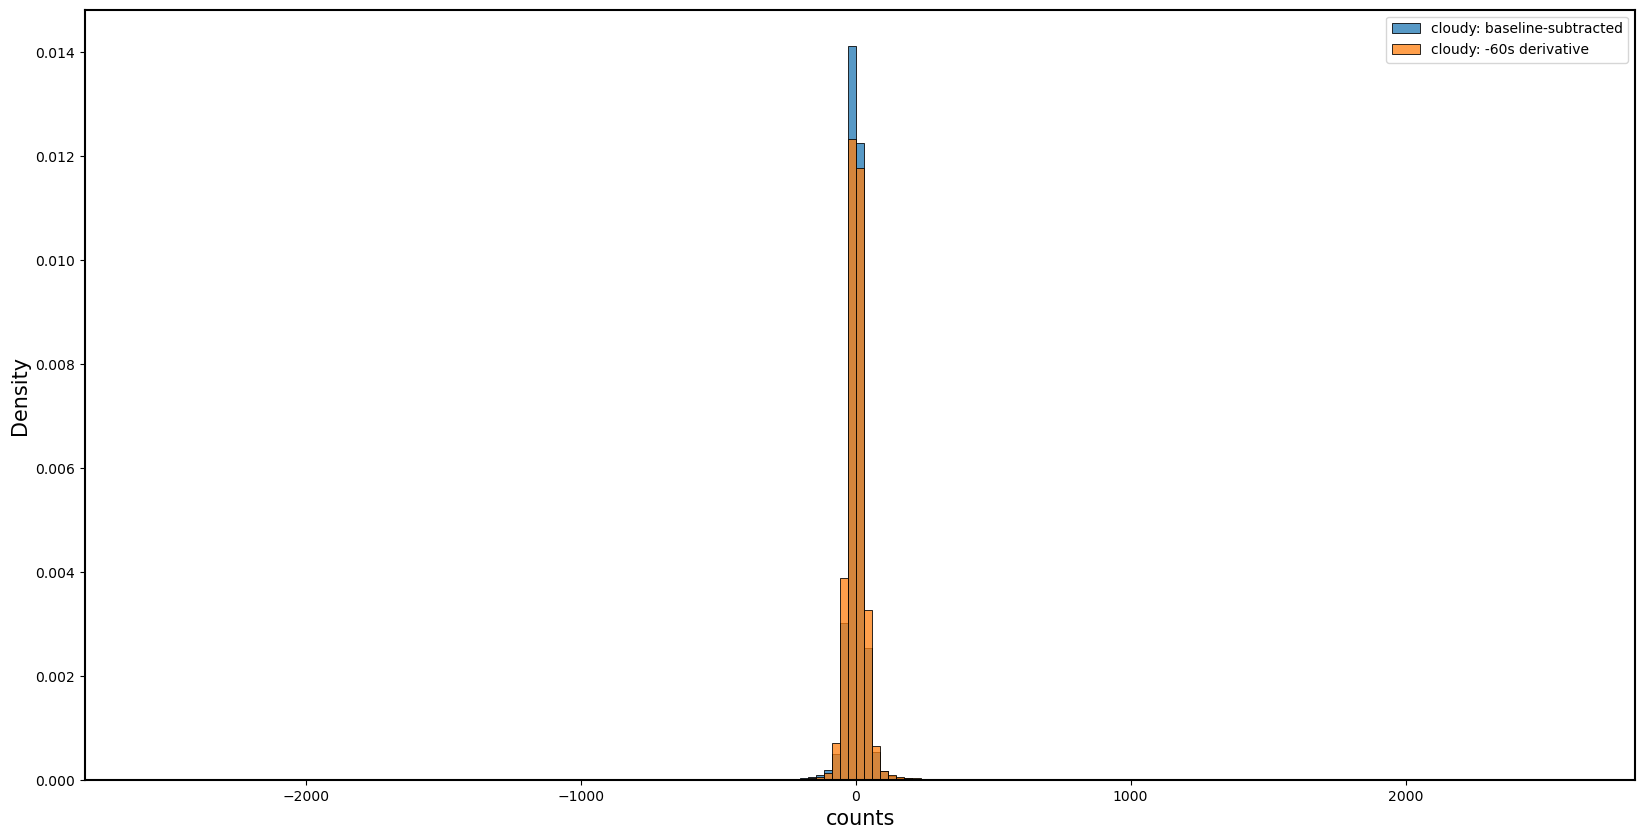

In [7]:
def plot_pixel_distribution(module_id, label):
    with_label = get_with_label(label, module_id)
    buffer_original = np.zeros((len(with_label), 32, 32))
    buffer_derivative = np.zeros((len(with_label), 32, 32))
    for i in range(len(with_label)):
        fuid = with_label['feature_uid'].iloc[i]
        buffer_original[i] = np.load(get_path(fuid, 'raw-original'))
        buffer_derivative[i] = np.load(get_path(fuid, 'raw-derivative.-60'))

    plt.figure(figsize=(20,10))

    mu = np.mean(np.concatenate((buffer_original, buffer_derivative)).ravel())
    std = np.std(np.concatenate((buffer_original, buffer_derivative)).ravel())

    binrange = [mu - 5*std, mu + 5*std]
    bins = 175
    
    sns.histplot(
        buffer_original.ravel(), 
        stat='density', 
        label=label + ': baseline-subtracted', 
        binrange=binrange,
        bins=bins
    )

    sns.histplot(
        buffer_derivative.ravel(), 
        stat='density', 
        label=label + ': -60s derivative', 
        binrange=binrange,
        bins=bins
    )
    # sns.histplot(
    #     flat[flat_idxs, :, :].ravel(),
    #     stat='density',
    #     label='orig - (spatial medians) - supermedian',
    #     binrange=binrange,
    #     bins=bins
    # )
    
    plt.xlabel('counts')
    plt.legend()

plot_pixel_distribution(3, 'cloudy')

In [8]:
old_path = '/Users/nico/panoseti/panoseti-software/cloud-detection/dataset_construction/training_batch_data/task_cloud-detection.type_training.batch-id_3/task_cloud-detection.batch-id_3.type_pano.csv'
new_path = '/Users/nico/panoseti/panoseti-software/cloud-detection/dataset_construction/training_batch_data_zipfiles/training_batch_data_zipfiles/task_cloud-detection.type_training.batch-id_3/task_cloud-detection.batch-id_3.type_pano.csv'

old = pd.read_csv(old_path, index_col=0)
new = pd.read_csv(new_path, index_col=0)

In [9]:
uid_diff = pd.Series(list(set(new['pano_uid']) - set(old['pano_uid'])))

In [45]:
old[old['pano_uid'].isin(uid_diff)]

,pano_uid,batch_id,run_dir,fname,frame_offset,module_id,frame_unix_t


In [46]:
old

,pano_uid,batch_id,run_dir,fname,frame_offset,module_id,frame_unix_t
0,af09cb9ffe305def6d8fb61ded234feaad4c8426,3,obs_Lick.start_2023-10-12T04:28:34Z.runtype_en...,start_2023-10-12T04:29:24Z.dp_img16.bpp_2.modu...,963736,254,1.697085e+09
1,e5d351edd22700d802600f4ec87bd9046b1cd79c,3,obs_Lick.start_2023-10-12T04:28:34Z.runtype_en...,start_2023-10-12T04:32:08Z.dp_img16.bpp_2.modu...,138932,254,1.697085e+09
2,2a3a6c3744d96e0f441aa034421247d76c6943fe,3,obs_Lick.start_2023-10-12T04:28:34Z.runtype_en...,start_2023-10-12T04:32:08Z.dp_img16.bpp_2.modu...,1148932,254,1.697085e+09
3,239d4cecb566c588f4ae4cfca6a47d5c6b14cff0,3,obs_Lick.start_2023-10-12T04:28:34Z.runtype_en...,start_2023-10-12T04:34:45Z.dp_img16.bpp_2.modu...,334128,254,1.697085e+09
4,801abbd632ba3d73313024a8dcc6b4e2fa8e2e1b,3,obs_Lick.start_2023-10-12T04:28:34Z.runtype_en...,start_2023-10-12T04:34:45Z.dp_img16.bpp_2.modu...,834128,254,1.697085e+09
...,...,...,...,...,...,...,...
418,4ba86fc1f44e2ad282ba77941280c47abd42e9af,3,obs_Lick.start_2023-10-12T04:28:34Z.runtype_en...,start_2023-10-12T06:56:31Z.dp_img16.bpp_2.modu...,1382775,3,1.697094e+09
419,194aaac4ef7cb2d4d3c95d839b96891831503896,3,obs_Lick.start_2023-10-12T04:28:34Z.runtype_en...,start_2023-10-12T06:59:09Z.dp_img16.bpp_2.modu...,317971,3,1.697094e+09
420,4edfa175fdfac2c40b4edd13a5bc2cb874828c70,3,obs_Lick.start_2023-10-12T04:28:34Z.runtype_en...,start_2023-10-12T06:59:09Z.dp_img16.bpp_2.modu...,1067971,3,1.697094e+09
421,86ebe0ef28ee81e1f90f64de78e2194c6590de51,3,obs_Lick.start_2023-10-12T04:28:34Z.runtype_en...,start_2023-10-12T07:01:46Z.dp_img16.bpp_2.modu...,3167,3,1.697094e+09


In [17]:
all(new['pano_uid'] == old['pano_uid'])

True

In [17]:
from time import sleep


def plot_frame(module_id, label, step, i):
    with_label = get_with_label(label, module_id)
    fuid, actual_module_id, date = with_label[['feature_uid', 'module_id', 'date']].iloc[i - 1]
    data = np.load(get_path(fuid, img_type))    
    fig, axs = plt.subplots(1, 3, figsize=(10.5, 4.8), constrained_layout=True)
    # fig.suptitle(f'[{label}] feature_uid: {fuid[:9]:>10}; ({(i-1)//step + 1} / {len(with_label) // step})')
    fig.suptitle(f'[inference: "{label}"] '
                 f'[module: {actual_module_id}] '
                 f'[fuid: {fuid[:9]}] '
                 f'[seqno: {i} / {len(with_label)}]\n'
                 f'[UTC: {date}]')

    # FFT of original stacked original
    fft_idx = 0
    # shape = (64, 64)
    data = np.load(get_path(fuid, 'raw-derivative-fft.-60'))
    window_type = "hann"
    # data = data * window(window_type, data.shape)
    # # data[data < 0] = 1
    # data = np.abs(fftn(data, shape))
    # data = fftshift(data)
    # data = np.log(data)
    im_fft = axs[fft_idx].imshow(
        data, vmin=3.5, vmax=12, cmap='mako'
    )
    cbar_fft = fig.colorbar(im_fft, label='$\log|X[k, \ell]|$', fraction=0.046, location='bottom')
    axs[fft_idx].axis('off')
    axs[fft_idx].set_title('FFT of Derivative')

    # Original stacked pano image
    orig_idx = 2
    orig = np.load(get_path(fuid, 'raw-fft'))
    sns.histplot(orig.ravel(), stat='density', binrange=[-1000, 1000], label='orig')

    orig = scale_data(orig)
    im_orig = axs[1].imshow(
        orig, vmin=-10**2, vmax=10**2, cmap='icefire'#cmap='crest_r'
    )
    cbar_orig = fig.colorbar(im_orig, label='Counts', fraction=0.046, location='bottom')
    axs[1].axis('off')
    axs[1].set_title('Original [6ms integr.]')

    # -60 second time derivative
    deriv_idx = 1
    deriv_data = np.load(get_path(fuid, 'raw-derivative-fft.-60'))
    # deriv_data = scale_data(deriv_data)
    # im_deriv = axs[deriv_idx].imshow(
    #     deriv_data, vmin=-10**2, vmax=10**2, cmap='icefire'
    # )
    sns.histplot(deriv_data.ravel(), stat='density', binrange=[-1000, 1000], label='deriv')
    # cbar_deriv = fig.colorbar(im_deriv, label = r'$\Delta$ Counts', fraction=0.046, location='bottom')
    # axs[deriv_idx].axis('off')
    # axs[orig_idx].set_title('Derivative: Orig(0s) – Orig(-60s)')
    plt.legend()
    plt.show()
    plt.close()



def do_movie(label, step, start_frame=1, frame_time=0.01, module_id=None):
    try:
        # for i, fuid in enumerate(with_label['feature_uid'][::step]):
        with_label = get_with_label(label, module_id)

        for i in range(max(min(start_frame, len(with_label)), 1), len(with_label) + 1, step):
            plot_frame(module_id, label, step, i)
            display.clear_output(wait=True)
            # plt.show()
            sleep(frame_time)
            # plt.close()
        print('Done')
    except KeyboardInterrupt:
        print('Exiting...')
        return
    finally:
        plt.close()
        gc.collect()
do_movie(label = 'cloudy', step=2, start_frame=0, module_id=1, frame_time=1)

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Exiting...


KeyboardInterrupt: 

In [53]:
{'raw-original', 'raw-fft', 'raw-derivative.-60', 'raw-derivative-fft.-60'}

{'raw-derivative-fft.-60', 'raw-derivative.-60', 'raw-fft', 'raw-original'}

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

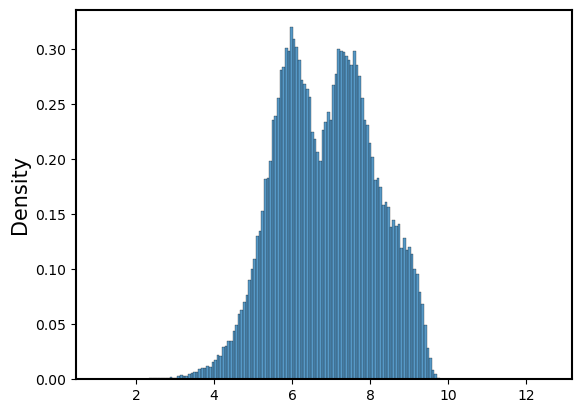

In [35]:
with_label = get_with_label('cloudy', 1)
fuids = with_label['feature_uid']
data = []
for fuid in fuids:
    data.append(np.load(get_path(fuid, 'raw-derivative-fft.-60')))
data = np.array(data)
sns.histplot(data.ravel(), stat='density')